# ECG Heartbeat Categorization Dataset

SEOYEON CHOI  
2025-08-18

[ECG Heartbeat Categorization
Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat?resource=download)

Abstract - This dataset is composed of two collections of heartbeat
signals derived from two famous datasets in heartbeat classification,
the MIT-BIH Arrhythmia Dataset and The PTB Diagnostic ECG Database. The
number of samples in both collections is large enough for training a
deep neural network. - This dataset has been used in exploring heartbeat
classification using deep neural network architectures, and observing
some of the capabilities of transfer learning on it. The signals
correspond to electrocardiogram (ECG) shapes of heartbeats for the
normal case and the cases affected by different arrhythmias and
myocardial infarction. These signals are preprocessed and segmented,
with each segment corresponding to a heartbeat.

Content

-   Arrhythmia Dataset
-   Number of Samples: 109446
-   Number of Categories: 5
-   Sampling Frequency: 125Hz
-   Data Source: Physionet’s MIT-BIH Arrhythmia Dataset
-   Classes: \[‘N’: 0, ‘S’: 1, ‘V’: 2, ‘F’: 3, ‘Q’: 4\]

The PTB Diagnostic ECG Database - Number of Samples: 14552 - Number of
Categories: 2 - Sampling Frequency: 125Hz - Data Source: Physionet’s PTB
Diagnostic Database - Remark: All the samples are cropped, downsampled
and padded with zeroes if necessary to the fixed dimension of 188.

Data Files - This dataset consists of a series of CSV files. Each of
these CSV files contain a matrix, with each row representing an example
in that portion of the dataset. The final element of each row denotes
the class to which that example belongs.

Acknowledgements - Mohammad Kachuee, Shayan Fazeli, and Majid
Sarrafzadeh. “ECG Heartbeat Classification: A Deep Transferable
Representation.” arXiv preprint arXiv:1805.00794 (2018).

Inspiration - Can you identify myocardial infarction?

# Import

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

import pywt

from scipy.stats import f_oneway

import scikit_posthocs as sp

from scipy.stats import kruskal

from scipy.stats import skew, kurtosis
from scipy.fft import rfft, rfftfreq

# 데이터 이해 & 전처리

데이터셋 구성 확인

In [2]:
df = pd.read_csv('../../../delete/mitbih_test.csv',header=None)

In [3]:
df.head(5)

5 rows × 188 columns

In [4]:
df.shape

(21892, 188)

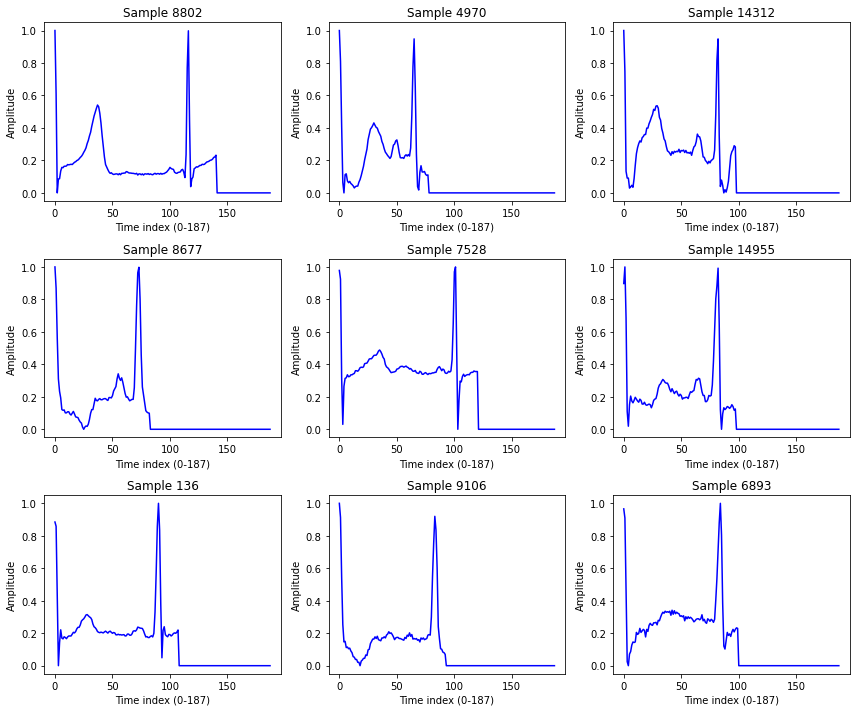

In [5]:
sample_idx = np.random.choice(df.shape[0], 9, replace=False)

plt.figure(figsize=(12, 10))

for i, idx in enumerate(sample_idx, 1):
    ecg = df.iloc[idx, :-1].values if df.shape[1] > 188 else df.iloc[idx, :].values
    
    plt.subplot(3, 3, i)
    plt.plot(ecg, color="blue")
    plt.title(f"Sample {idx}")
    plt.xlabel("Time index (0-187)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [6]:
df[187].unique()

array([0., 1., 2., 3., 4.])

-   MIT-BIH (부정맥 → 5 classes)

전처리

-   Normalization (z-score scaling)
-   Train/Validation/Test split

In [7]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [8]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.20, random_state=42, stratify=y_train_full
)

In [9]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)   # fit은 train만!
X_val_std   = scaler.transform(X_val)
X_test_std  = scaler.transform(X_test)

# 탐색적 데이터 분석 (EDA)

평균 파형 시각화

In [10]:
label_col = df.columns[-1]
feature_cols = df.columns[:-1]
n_points = len(feature_cols)

In [11]:
fs = 125.0
t = np.arange(n_points) / fs

In [12]:
label_map = {0:'N', 1:'S', 2:'V', 3:'F', 4:'Q'}

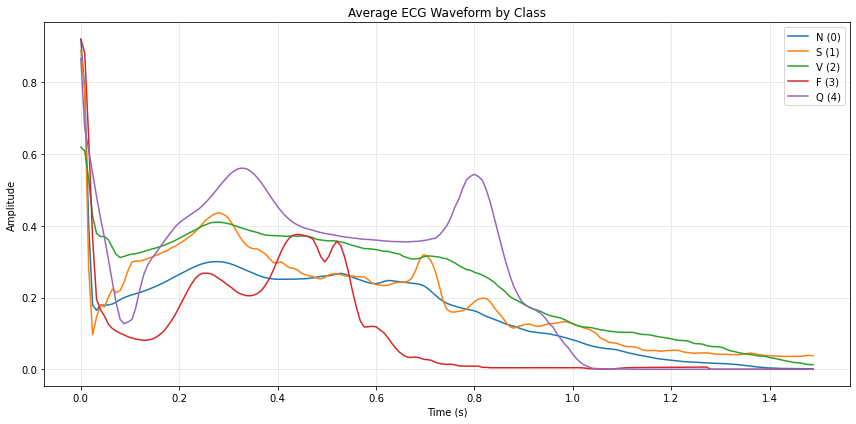

In [13]:
# 라벨별 평균 파형 계산
means = []
labels_present = sorted(df[label_col].unique())
for y in labels_present:
    m = df.loc[df[label_col] == y, feature_cols].mean(axis=0).values
    means.append((y, m))

# 한 그래프에 라벨별 평균 파형 그리기
plt.figure(figsize=(12,6))
for y, m in means:
    plt.plot(t, m, label=f"{label_map.get(int(y), y)} ({int(y)})")
plt.title("Average ECG Waveform by Class")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

스펙트럼 분석 - FFT or Wavelet 변환을 통한 frequency 특징 비교.

FFT

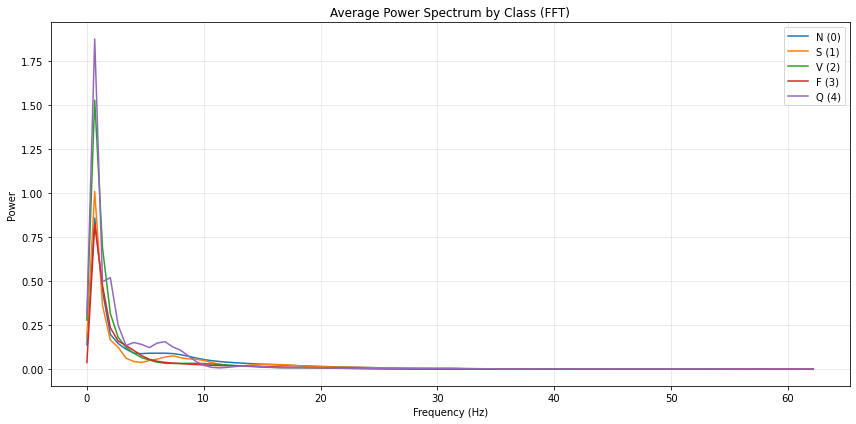

In [14]:
# ----- 기본 설정 -----
fs = 125.0
label_col = df.columns[-1]
feature_cols = df.columns[:-1]
N = len(feature_cols)               # 188
t = np.arange(N) / fs
freqs = np.fft.rfftfreq(N, d=1/fs)  # 0 ~ Nyquist(62.5 Hz)
window = np.hanning(N)              # 한닝 윈도우(누설 감소)

# 라벨 매핑(가독성)
label_map = {0:'N', 1:'S', 2:'V', 3:'F', 4:'Q'}

# ----- 클래스별 평균 파워 스펙트럼 -----
plt.figure(figsize=(12,6))
for y in sorted(df[label_col].unique()):
    X = df.loc[df[label_col] == y, feature_cols].values    # (n_class_samples, N)
    # detrend(평균 제거) + windowing + FFT
    X_detrended = X - X.mean(axis=1, keepdims=True)
    Xw = X_detrended * window
    F = np.fft.rfft(Xw, axis=1)
    P = (np.abs(F)**2) / (window**2).sum()                 # 파워 정규화
    P_mean = P.mean(axis=0)

    plt.plot(freqs, P_mean, label=f"{label_map.get(int(y), y)} ({int(y)})")

plt.title("Average Power Spectrum by Class (FFT)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Wavelet

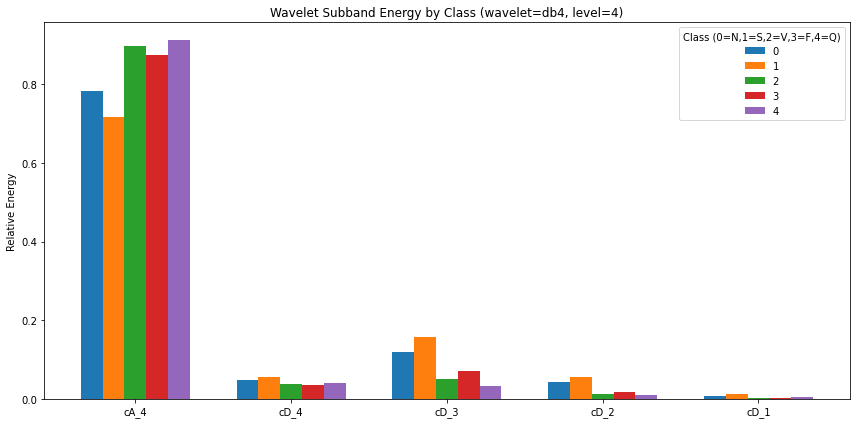

In [15]:
# ----- DWT 파라미터 -----
wavelet = 'db4'
level = 4 # 188 포인트면 4~5레벨 적당

# 한 샘플에서 서브밴드 에너지 벡터 추출
def wavelet_band_energy(x):
    # 평균 제거(기저선 영향 완화)
    x = x - x.mean()
    coeffs = pywt.wavedec(x, wavelet=wavelet, level=level)
    # coeffs = [cA_L, cD_L, cD_{L-1}, ..., cD_1]
    energies = [np.sum(c**2) for c in coeffs]
    total = np.sum(energies) + 1e-12
    # 상대 에너지(합=1)로 반환하면 샘플 간 진폭 차이 영향 완화
    return np.array(energies) / total

# 전체 샘플 처리
feat_list = []
labels = []
for _, row in df.iterrows():
    x = row[feature_cols].values.astype(float)
    e = wavelet_band_energy(x)
    feat_list.append(e)
    labels.append(int(row[label_col]))

E = np.vstack(feat_list)   # shape: (n_samples, 1 + level)
y = np.array(labels)

# 클래스별 평균 상대 에너지
classes = sorted(np.unique(y))
E_mean = {c: E[y==c].mean(axis=0) for c in classes}

# 플롯: 각 클래스의 subband 에너지 비교 (막대그래프)
bands = [f"cA_{level}"] + [f"cD_{i}" for i in range(level, 0, -1)]  # 상위 스케일→하위 스케일
x_pos = np.arange(len(bands))

plt.figure(figsize=(12,6))
bar_width = 0.14
for i, c in enumerate(classes):
    plt.bar(x_pos + i*bar_width, E_mean[c], width=bar_width, label=f"{c}")

plt.xticks(x_pos + bar_width*(len(classes)-1)/2, bands)
plt.ylabel("Relative Energy")
plt.title(f"Wavelet Subband Energy by Class (wavelet={wavelet}, level={level})")
plt.legend(title="Class (0=N,1=S,2=V,3=F,4=Q)")
plt.tight_layout()
plt.show()

통계적 비교 - Classes: \[‘N’: 0, ‘S’: 1, ‘V’: 2, ‘F’: 3, ‘Q’: 4\] 간에
amplitude, variance, QRS duration 등 특징 차이 통계 검정 (t-test,
Mann-Whitney).

In [16]:
df['amp_mean'] = df.iloc[:, :-1].mean(axis=1)
df['amp_max']  = df.iloc[:, :-1].max(axis=1)
df['amp_min']  = df.iloc[:, :-1].min(axis=1)
df['amp_range'] = df['amp_max'] - df['amp_min']

In [17]:
df['variance'] = df.iloc[:, :-1].var(axis=1)

In [18]:
def qrs_duration(signal, threshold_ratio=0.5):
    # R peak amplitude 추정
    peak = np.max(signal)
    threshold = peak * threshold_ratio
    above = np.where(signal >= threshold)[0]
    if len(above) == 0:
        return 0
    return above[-1] - above[0]   # index 차이 (포인트 수)

df['qrs_dur'] = df.iloc[:, :-1].apply(lambda row: qrs_duration(row.values), axis=1)

In [19]:
label_map = {0:'N', 1:'S', 2:'V', 3:'F', 4:'Q'}

desc = df.groupby(df.iloc[:, -1])[['amp_mean','variance','qrs_dur']].describe()

In [20]:
groups = [df.loc[df.iloc[:, -1] == c, 'amp_mean'] for c in sorted(df.iloc[:, -1].unique())]
anova_amp = f_oneway(*groups)

groups = [df.loc[df.iloc[:, -1] == c, 'variance'] for c in sorted(df.iloc[:, -1].unique())]
anova_var = f_oneway(*groups)

groups = [df.loc[df.iloc[:, -1] == c, 'qrs_dur'] for c in sorted(df.iloc[:, -1].unique())]
anova_qrs = f_oneway(*groups)

print("ANOVA amp_mean:", anova_amp)
print("ANOVA variance:", anova_var)
print("ANOVA qrs_dur:", anova_qrs)

ANOVA amp_mean: F_onewayResult(statistic=97.23061517562662, pvalue=0.0)
ANOVA variance: F_onewayResult(statistic=673.9205351617329, pvalue=0.0)
ANOVA qrs_dur: F_onewayResult(statistic=inf, pvalue=0.0)

/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3903: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))

In [21]:
groups = [df.loc[df.iloc[:, -1] == c, 'amp_mean'] for c in sorted(df.iloc[:, -1].unique())]
kw_amp = kruskal(*groups)

groups = [df.loc[df.iloc[:, -1] == c, 'variance'] for c in sorted(df.iloc[:, -1].unique())]
kw_var = kruskal(*groups)

groups = [df.loc[df.iloc[:, -1] == c, 'qrs_dur'] for c in sorted(df.iloc[:, -1].unique())]
kw_qrs = kruskal(*groups)

print("Kruskal amp_mean:", kw_amp)
print("Kruskal variance:", kw_var)
print("Kruskal qrs_dur:", kw_qrs)

Kruskal amp_mean: KruskalResult(statistic=4731.5315295296, pvalue=0.0)
Kruskal variance: KruskalResult(statistic=8376.756741998353, pvalue=0.0)
Kruskal qrs_dur: KruskalResult(statistic=21891.0, pvalue=0.0)

In [22]:
posthoc_amp = sp.posthoc_dunn(df, val_col='amp_mean', group_col=df.columns[-1], p_adjust='bonferroni')
print(posthoc_amp)

               4    5    6    7    9    10   12   14   15   16   ...  182  \
4     1.000000e+00  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
5     1.000000e+00  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
6     1.000000e+00  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
7     1.000000e+00  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
9     1.000000e+00  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
..             ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
187   1.353411e-35  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
188   3.901249e-05  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
189   1.318389e-12  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
190   2.638355e-03  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
191  4.113517e-283  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   

     183       184           185            186            187           18

In [23]:
# 예: amp_mean 특징을 클래스별 비교
posthoc_amp = sp.posthoc_dunn(
    df, 
    val_col='amp_mean', 
    group_col=df.columns[-1],  # 마지막 열이 라벨
    p_adjust='bonferroni'
)

print("Dunn post-hoc test (amp_mean):")
print(posthoc_amp)

Dunn post-hoc test (amp_mean):
               4    5    6    7    9    10   12   14   15   16   ...  182  \
4     1.000000e+00  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
5     1.000000e+00  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
6     1.000000e+00  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
7     1.000000e+00  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
9     1.000000e+00  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
..             ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
187   1.353411e-35  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
188   3.901249e-05  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
189   1.318389e-12  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
190   2.638355e-03  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
191  4.113517e-283  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   

     183       184           185            

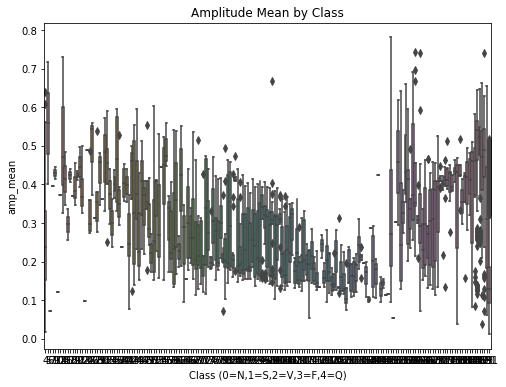

In [24]:
# Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x=df.iloc[:, -1], y=df['amp_mean'])
plt.title("Amplitude Mean by Class")
plt.xlabel("Class (0=N,1=S,2=V,3=F,4=Q)")
plt.ylabel("amp_mean")
plt.show()

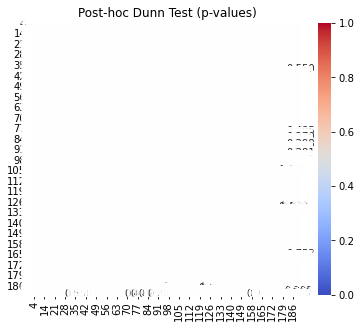

In [25]:
# Posthoc heatmap
plt.figure(figsize=(6,5))
sns.heatmap(posthoc_amp, annot=True, cmap="coolwarm", cbar=True, fmt=".3f")
plt.title("Post-hoc Dunn Test (p-values)")
plt.show()

# 특징 기반 머신러닝 접근

특징 추출 - 시간영역: mean, std, skewness, kurtosis, peak-to-peak -
주파수영역: dominant frequency, power spectrum - Wavelet: ST segment
관련 coefficient

In [26]:
def extract_time_features(x):
    return {
        'mean': float(np.mean(x)),
        'std': float(np.std(x)),
        'skew': float(skew(x)),
        'kurtosis': float(kurtosis(x)),
        'ptp': float(np.ptp(x)),  # peak-to-peak
    }

def extract_freq_features(x, fs=125):
    N = len(x)
    freqs = rfftfreq(N, d=1/fs)
    spectrum = np.abs(rfft(x))**2
    dom_freq = float(freqs[np.argmax(spectrum)])
    power = float(np.sum(spectrum))
    return {'dom_freq': dom_freq, 'power': power}

def extract_wavelet_features(x, wavelet='db4', level=4):
    x = x - x.mean()
    coeffs = pywt.wavedec(x, wavelet=wavelet, level=level)
    energies = [np.sum(c**2) for c in coeffs]
    total = np.sum(energies) + 1e-12
    rel = [float(e/total) for e in energies]
    # cA_L, cD_L, ..., cD_1
    names = [f'wavelet_energy_cA_{level}'] + [f'wavelet_energy_cD_{i}' for i in range(level, 0, -1)]
    return dict(zip(names, rel))

def extract_features(x, fs=125):
    feats = {}
    feats.update(extract_time_features(x))
    feats.update(extract_freq_features(x, fs=fs))
    feats.update(extract_wavelet_features(x))
    return feats

In [27]:
# ---- 라벨/피처 컬럼 안전하게 정의 ----
label_col = df.columns[-1]              # 마지막 열을 라벨로 사용
feature_cols = df.columns[:-1]          # 나머지는 ECG 시계열

# ---- 넘파이로 뽑아서 루프 (빠르고 안전) ----
X = df.loc[:, feature_cols].to_numpy(dtype=float)
y = df.loc[:, label_col].to_numpy()

feature_list = []
labels = []

for xi, yi in zip(X, y):
    feats = extract_features(xi, fs=125)
    feature_list.append(feats)
    labels.append(int(yi))

feature_df = pd.DataFrame(feature_list)
feature_df['label'] = labels

print(feature_df.head())
print(feature_df.shape)

       mean       std      skew   kurtosis  ptp  dom_freq        power  \
0  0.088813  0.165259  4.148272  18.524207  1.0       0.0   802.459636   
1  0.201932  0.247202  1.129980   0.747387  1.0       0.0  2657.005592   
2  0.119641  0.163150  2.984116  12.369159  1.0       0.0  1028.928658   
3  0.168079  0.222119  1.874741   3.945423  1.0       0.0  1971.182895   
4  0.207004  0.219523  1.185874   1.866668  1.0       0.0  2493.665686   

   wavelet_energy_cA_4  wavelet_energy_cD_4  wavelet_energy_cD_3  \
0             0.581605             0.070714             0.143888   
1             0.781645             0.074139             0.056645   
2             0.494606             0.057453             0.107020   
3             0.792486             0.068899             0.062562   
4             0.613792             0.090211             0.101761   

   wavelet_energy_cD_2  wavelet_energy_cD_1  label  
0             0.068162             0.135632    191  
1             0.009751             0.077

ML 모델링 - Logistic Regression, Random Forest, XGBoost - 목표: baseline
accuracy/ROC-AUC 확인

# 딥러닝 접근 (Raw Signal 사용)

1D CNN

Local ECG pattern (QRS, ST-segment)을 자동으로 학습.

LSTM/GRU

ECG 신호의 순차적 dependency 반영.

CNN+LSTM 하이브리드

CNN → local features 추출 → LSTM → temporal dependency 반영.

Output: Binary classification (Normal=0, MI=1).

Transfer Learning (핵심 부분)

Step 1: MIT-BIH arrhythmia dataset으로 CNN 모델 사전학습 (heartbeat
classification).

Step 2: Feature extractor 부분을 PTB 데이터로 fine-tuning → 심근경색
탐지.

Expected Outcome: 작은 PTB 데이터셋에서도 높은 accuracy 달성 가능.

모델 평가

Metrics: Accuracy, Precision, Recall, F1, ROC-AUC

임상적 중요성: Sensitivity (Recall, true positive rate) 특히 중요 → MI
놓치면 위험.

Cross-validation: 환자 단위 cross-validation으로 generalization 검증.

Explainability & Interpretability

Grad-CAM / Saliency maps: 모델이 ECG 파형 중 어느 부분(QRS, ST
elevation)에 주목하는지 확인.

SHAP / LIME: 특징 기반 모델에서 MI 판별에 기여한 변수 확인.

의학적 해석 연결: ST segment elevation → MI의 전형적 패턴임을 보여주면
신뢰성 강화.

실제 응용

실시간 심전도 모니터링 (웨어러블 기기, 병원 장비)

조기 경고 시스템: 심근경색 발생 시 자동 alert

임상 보조 도구: 의사의 판독을 보조하는 AI